In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#reading in file
df = pd.read_csv('annotations_data.csv')

## Code for creating visualisations

In [3]:
#helper method to count the number of times an answer appears in a column
def count_answers(column):

    method_dic = {}

    for method in column:
        options = method.split(", ") 
        for option in options:
            option = option.lower()
            if option not in method_dic: #checks if it is a different answer           
                method_dic[option] = 1
            else: 
                method_dic[option] = method_dic.get(option)+1
             
    return method_dic

In [4]:
#helper method to add a threshold, so options that only are represented in one article are
#gathered in an other option to be visualised

def threshold_added(data):
    
    dataframe = pd.DataFrame.from_dict(data)
 
    df = dataframe.fillna(0)

    df['sum'] = df.sum(axis = 1)

    other= [0,0] #[2012, 2021]

    for index in range(len(df)):
        if df.iloc[index, 0] + df.iloc[index, 1] <= 2: #testing the threshold value
            other[0] = other[0] + df.iloc[index, 0]
            other[1] = other[1] + df.iloc[index, 1]
    
    if other[0] != 0 and other[1] !=0: #making sure this only happens if the other category is used
        
        data = df.drop(df[df['sum'] <= 2].index) #testing the threshold value
        data = data.drop('sum', axis = 1)
        data = data.reset_index()
    
        data = data.append({'index': 'other','2012':other[0], '2021':other[1]}, ignore_index=True)
    
        data = data.set_index('index')
    
    else: data = dataframe #for the dataset type options this is not used, and we simply 
        #need the original dataframe
    
    return data


In [5]:
#main method to create vizualisations 

def create_viz(df, column, name, count_option):
    #narrowing down the df to classification labelled accurately and splitting into 2012 and 2021
    df_true = df[df['Is the article accurately labelled as classification?'] == 'Yes']
    df_2012 = df_true[df_true['Which year is the article from?'] == 2012]
    df_2021 = df_true[df_true['Which year is the article from?'] == 2021]
    
    #counting the answers 
    if count_option == 'multiple choice':
        data = {'2012': count_answers(df_2012.iloc[:, column]),
       '2021': count_answers(df_2021.iloc[:, column])}
        df = threshold_added(data)
        color_dic = {'public': '#066570', 'private': '#5eb1bf'}
    
    elif count_option == 'pub/priv':
        data = {'2012': percentage(count_pub_priv(df_2012, column), 2012),
       '2021': percentage(count_pub_priv(df_2021, column), 2021)}
        df = pd.DataFrame.from_dict(data)
        row_names = {0:"Public only", 1:"Private only", 2: "Mixed"}  
        df.rename(index= row_names, inplace=True)
        color_dic = {'Public only': '#066570', 'Private only': '#5eb1bf', 'Mixed' : 'grey'}

    elif count_option == 'y/n':
        data = {'2012': percentage(count_yes_no(df_2012, column),2012),
       '2021': percentage(count_yes_no(df_2021, column),2021)}
        
        df = pd.DataFrame.from_dict(data)
        row_names = {0:"Yes", 1:"No"}  
        df.rename(index= row_names, inplace=True)
        color_dic = {'Yes': '#066570', 'No': '#5eb1bf'}
          

    #drawing the figure with a helper function
    if 'used' in name:
        color_dic = {'2012': '#066570', '2021': '#5eb1bf'} #fixing the colors for this type of viz
        #sorting the df by total sum pr row
        total=df.sum(axis = 1)
        df['total'] = total
        df = df.sort_values(by=['total'], ascending=True)
        df.drop('total', axis = 1, inplace = True)
 
        draw_fig(df, 'barh', name, False, color_dic, 0, 'hide')
    
    else:
        df = df.transpose()
        draw_fig(df, 'bar', name, True, color_dic, 45, 'show')
          
    return df


In [18]:
#helper function to actually draw non-ethics figures

def draw_fig(df, plot_option, name, stacked_option, color_dic, rotation_angle, annotations_option):
    fig = df.plot(kind = plot_option, title = name, stacked = stacked_option, color =color_dic)
    plt.xticks(rotation = rotation_angle)
    legend = fig.legend(loc='lower center')
    
    if annotations_option == 'show':
        fig.set_ylabel('percent of articles')
        for container in fig.containers:
            annotations = fig.bar_label(container, label_type='center', color = 'white')
            #removing annotations that are equal to 0 for nicer graphs
            for annotation in annotations:
                if float(annotation.get_text()) == 0.0:
                    annotation.set(visible = False)
    else:
        fig.set_xlabel('number of articles')
        fig.set_ylabel(name[:-5])
    plt.savefig(name , bbox_inches='tight')
    
    return fig

In [7]:
#used with a later method to create separate ethics vizualisations
ethics_columns = [25, 27, 29, 31]

In [8]:
#helper method to count number of public/private answers in a column

def count_pub_priv(df, column):
    dataset_answer_list = [0,0,0] #[pub, priv, mixed]
    for input in df[df.columns[column]]:
        if input == 'Public':
            dataset_answer_list[0] += 1
        elif input == 'Private':
            dataset_answer_list[1] += 1
        elif ',' in input:
            dataset_answer_list[2] += 1
    return dataset_answer_list


In [9]:
#helper method to make counts into percentages and rounding them to 1 decimal point

def percentage(answer_list, year):
    if year == 2021:
        total = 73
    else: total = 38
    
    percentage_list = []
    
    for index in range(len(answer_list)):
        percentage_list.append(0)
        percentage_list[index]=answer_list[index]/total*100
    
    rounded = [round(value, 1) for value in percentage_list]    
    return rounded

In [10]:
#helper method to count number of yes/no answers in a column

def count_yes_no(df, column):
    answer_list = [0,0] #[yes, no]
    for input in df[df.columns[column]]:
        if input == 'Yes':
            answer_list[0] += 1
        elif input == 'No':
            answer_list[1] += 1
    return answer_list

## Code for creating individual ethics visualisations

In [21]:
#this visualisation didn't end up in the thesis, did a combined version further down
#main method for creating sepearate ethics visualisations 
def create_ethics_viz(df, columns, plot_option, name, year):
    #narrowing down the df to classification labelled accurately and splitting into 2012 and 2021
    df_true = df[df['Is the article accurately labelled as classification?'] == 'Yes']
    if year == 2012:
        df = df_true[df_true['Which year is the article from?'] == 2012]
    else:
        df = df_true[df_true['Which year is the article from?'] == 2021]
    
    #counting the answers
    data = {column:[] for column in columns}
    for column in columns:
        data[column] = count_yes_no(df, column)
    df = pd.DataFrame(data) 
    
    #renaming columns and rows

    column_names = {columns[0]:'Respect for persons', columns[1]:'Beneficence', 
                    columns[2]:'Justice', columns[3]:'Repect for law/public interest'}
  
    row_names = {0:"Yes", 1:"No"}

    df.rename(index= row_names, columns = column_names, inplace=True)
    
    
    color_dic = {'Yes': '#066570', 'No': '#5eb1bf'}
    
    
    fig = df.transpose().plot(kind = plot_option, title = name, stacked = True, color = color_dic)
    
    for container in fig.containers:
        annotations = fig.bar_label(container, label_type='center', color = 'white') 
        #removing annotations that are equal to 0 for nicer graphs
        for annotation in annotations:
            if int(annotation.get_text()) == 0:
                annotation.set(visible = False)
            
            
    fig.set_xlabel("number of articles")
    fig.legend( loc='lower center', ncol=3)
    plt.savefig(name , bbox_inches='tight')



    return df

## Creating the visualisations 

,Yes,No
2012,55.3,44.7
2021,15.1,84.9


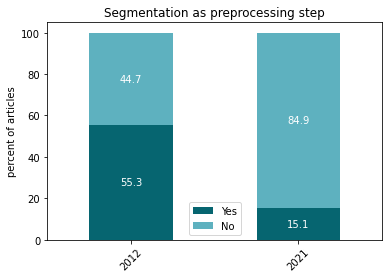

In [12]:
create_viz(df, 10, 'Segmentation as preprocessing step', 'y/n')

,Public only,Private only,Mixed
2012,21.1,73.7,5.3
2021,58.9,28.8,12.3


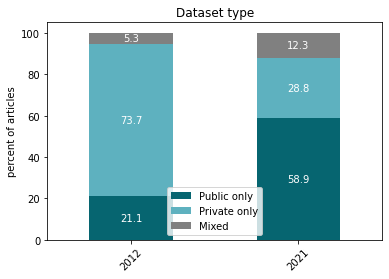

In [13]:
create_viz(df, 15, 'Dataset type', 'pub/priv')

,Yes,No
2012,50.0,50.0
2021,79.5,20.5


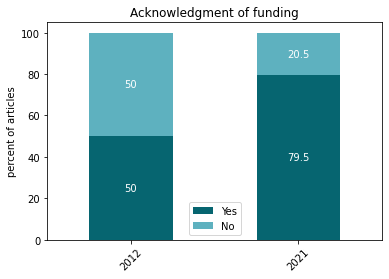

In [14]:
create_viz(df, 23, 'Acknowledgment of funding', 'y/n')

,2012,2021
index,,
logistic classifier,3.0,0.0
unsupervised learning,2.0,2.0
self supervised learning,0.0,8.0
graph analysis,4.0,7.0
svm,16.0,1.0
other,19.0,10.0
neural network,1.0,61.0


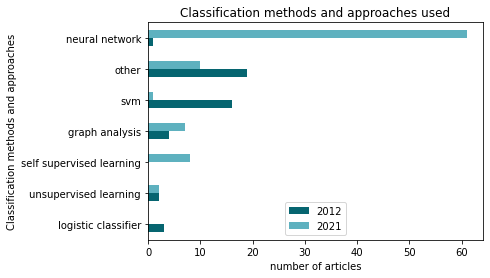

In [19]:
create_viz(df, 8, 'Classification methods and approaches used', 'multiple choice')

,2012,2021
index,,
concordance index,0.0,4.0
other,6.0,13.0
recall,9.0,14.0
specificity,8.0,15.0
sensitivity,11.0,14.0
precision,10.0,16.0
f1 score,3.0,23.0
auc,9.0,35.0
accuracy,26.0,38.0


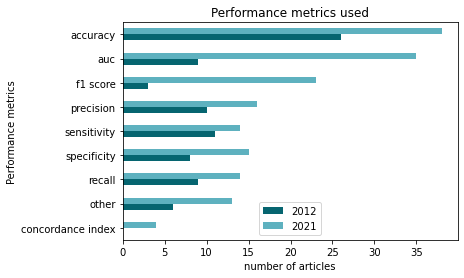

In [20]:
create_viz(df, 9, 'Performance metrics used', 'multiple choice')

,Respect for persons,Beneficence,Justice,Repect for law/public interest
Yes,1,1,0,8
No,37,37,38,30


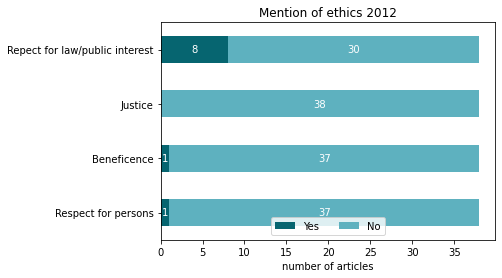

In [22]:
create_ethics_viz(df, ethics_columns, 'barh', 'Mention of ethics 2012', 2012)

,Respect for persons,Beneficence,Justice,Repect for law/public interest
Yes,8,1,0,45
No,65,72,73,28


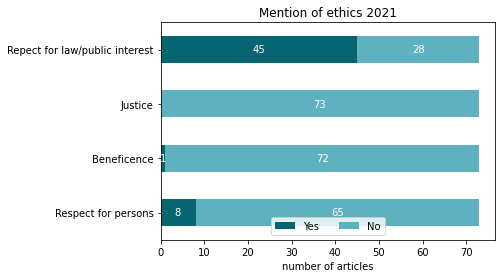

In [23]:
create_ethics_viz(df, ethics_columns, 'barh', 'Mention of ethics 2021', 2021)

## Creating combined ethics vizualisation

I added some additional axis annotations to this graph in paint after the fact, but this is the base code for the graph in my thesis

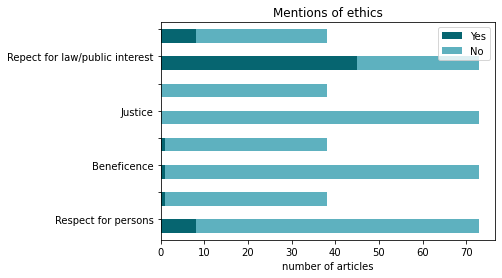

In [24]:

df_true = df[df['Is the article accurately labelled as classification?'] == 'Yes']
df2012 = df_true[df_true['Which year is the article from?'] == 2012]
df2021 = df_true[df_true['Which year is the article from?'] == 2021]

columns =  [25, 27, 29, 31]

ethics_data12 ={}
ethics_data21={}
for column in columns:
    ethics_data12[column+12] = count_yes_no(df2012, column)
    ethics_data21[column] =  count_yes_no(df2021, column)

res = ethics_data12 | ethics_data21
ethics_df = pd.DataFrame(res)
#rearranging the dataframe so ethics categories are next to each other
ethics_df = ethics_df[[25, 37, 27, 39, 29, 41, 31, 43]]

column_names = {37:'', 39:'', 
                    41:'', 43:'',
               25:'Respect for persons', 27:'Beneficence', 
                    29:'Justice', 31:'Repect for law/public interest'}
  
row_names = {0:"Yes", 1:"No"}
ethics_df.rename(index= row_names, columns = column_names, inplace=True)
ethics_df = ethics_df.transpose()

color_dic = {'Yes': '#066570', 'No': '#5eb1bf'}
fig = ethics_df.plot(kind = 'barh', title = 'Mentions of ethics', stacked = True, color = color_dic, position = 1)
fig.set_xlabel("number of articles")
plt.savefig("Mentions of ethics" , bbox_inches='tight')


 